In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/energy-consumption-generation-prices-and-weather/energy_dataset.csv
/kaggle/input/energy-consumption-generation-prices-and-weather/weather_features.csv


![](https://i.pinimg.com/originals/0c/ab/1c/0cab1c6c171b4e0d71ec822600f5923b.jpg)

# Predicting the Price of Electricty with Machine Learning

"Real-time electricity pricing models can potentially lead to economic and environmental advantages compared to the current common flat rates. In particular, they can provide end users with the opportunity to reduce their electricity expenditures by responding to pricing that varies with different times of the day. However, recent studies have revealed that the lack of knowledge among users about how to respond to time-varying prices as well as the lack of effective building automation systems are two major barriers for fully utilizing the potential benefits of real-time pricing tariffs. We tackle these problems by proposing an optimal and automatic residential energy consumption scheduling framework which attempts to achieve a desired trade-off between minimizing the electricity payment and minimizing the waiting time for the operation of each appliance in household in presence of a real-time pricing tariff combined with inclining block rates . Our design requires minimum effort from the users and is based on simple linear programming computations. Moreover, we argue that any residential load control strategy in real-time electricity pricing environments requires price prediction capabilities. This is particularly true if the utility companies provide price information only one or two hours ahead of time. Simulation results show that the combination of the proposed energy consumption scheduling design and the price predictor filter leads to significant reduction not only in users' payments but also in the resulting peak-to-average ratio in load demand for various load scenarios. Therefore, the deployment of the proposed optimal energy consumption scheduling schemes is beneficial for both end users and utility companies." -[Amir-Hamed Mohsenian-Rad](https://ieeexplore.ieee.org/abstract/document/5540263)




## Data Contents -

This dataset contains four years of electrical consumption, generation, pricing, and weather data for Spain. Consumption and generation data was retrieved from ENTSOE a public portal for Transmission Service Operator (TSO) data. Settlement prices were obtained from the Spanish TSO Red Electric España. 

## Column Meanings - 

* Time: Datetime index localized to CET
* Generation biomass: biomass generation in MW
* Generation fossil brown coal/lignite: coal/lignite generation in MW
* Generation fossil coal-derived gas: coal gas generation in MW
* Generation fossil gas: gas generation in MW
* Generation fossil hard coal: coal generation in MW
* Generation fossil oil: oil generation in MW
* Generation fossil oil shale: shale oil generation in MW
* Generation fossil peat: peat generation in MW
* Generation geothermal: geothermal generation in MW
* Generation hydro pumped storage aggregated: hydro1 generation in MW
* Generation hydro pumped storage consumption: hydro2 generation in MW
* Generation hydro run-of-river and poundage: hydro3 generation in MW
* Generation hydro water reservoir: hydro4 generation in MW
* Generation marine: sea generation in MW
* Generation nuclear: nuclear generation in MW
* Generation other: other generation in MW
* Generation other renewable: other renewable generation in MW
* Generation solar: solar generation in MW
* Generation waste: waste generation in MW
* Generation wind offshore: wind offshore generation in MW
* Generation wind onshore: wind onshore generation in MW
* Gorecast solar day ahead: forecasted solar generation
* Gorecast wind offshore eday ahead: forecasted offshore wind generation
* Gorecast wind onshore day ahead: forecasted onshore wind generation
* Total load forecast: forecasted electrical demand
* Total load actual: actual electrical demand
* Price day ahead: forecasted price EUR/MWh
* Price actual: price in EUR/MWh

In [2]:
# Import libraries -

# Visualization
import shap
%matplotlib inline
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance

# Data Wrangling
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',50)

# Model Creation
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge, LinearRegression
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV
from sklearn.metrics import roc_curve, plot_roc_curve, mean_absolute_error, mean_squared_error, accuracy_score

# Warnings Ignore
import warnings
warnings.filterwarnings("ignore")

# 1. Data Exploration / Clean - 



In [3]:
# Read in data
df = pd.read_csv('../input/energy-consumption-generation-prices-and-weather/energy_dataset.csv')

# Preview of data
df.head(5)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


## 1.1. Data Exploration -

In [4]:
# .Describe to show overview of data
df.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,35045.000000,35045.000000,35046.000000,35045.0,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,475.577343,972.116108,2605.114735,0.0,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,792.406614,400.777536,1835.199745,0.0,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,0.000000,637.000000,1077.250000,0.0,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,68.000000,906.000000,2164.000000,0.0,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,616.000000,1250.000000,3757.000000,0.0,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,4523.000000,2000.000000,9728.000000,0.0,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


In [5]:
# .Info to show datatype, nulls, and count
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [6]:
# Null % check amongst columns
round((df.isnull().sum()/len(df)*100),2)

time                                             0.00
generation biomass                               0.05
generation fossil brown coal/lignite             0.05
generation fossil coal-derived gas               0.05
generation fossil gas                            0.05
generation fossil hard coal                      0.05
generation fossil oil                            0.05
generation fossil oil shale                      0.05
generation fossil peat                           0.05
generation geothermal                            0.05
generation hydro pumped storage aggregated     100.00
generation hydro pumped storage consumption      0.05
generation hydro run-of-river and poundage       0.05
generation hydro water reservoir                 0.05
generation marine                                0.05
generation nuclear                               0.05
generation other                                 0.05
generation other renewable                       0.05
generation solar            

In [7]:
# DF.corr to show correlation of values
df.corr()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
generation biomass,1.000000,0.229809,NaN,-0.021660,0.433522,0.459530,NaN,NaN,NaN,NaN,-0.044898,-0.284877,-0.033675,NaN,-0.021279,0.658488,-0.560588,-0.004687,-0.346343,NaN,-0.068658,-0.008713,NaN,-0.072368,0.085216,0.083288,0.108945,0.142369
generation fossil brown coal/lignite,0.229809,1.000000,NaN,0.499808,0.768710,0.314869,NaN,NaN,NaN,NaN,-0.323771,-0.525005,-0.229455,NaN,-0.008440,0.097600,0.104552,0.040447,0.282810,NaN,-0.434118,0.042306,NaN,-0.436031,0.278503,0.280461,0.567905,0.364088
generation fossil coal-derived gas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
generation fossil gas,-0.021660,0.499808,NaN,1.000000,0.541635,0.309623,NaN,NaN,NaN,NaN,-0.420646,-0.271527,0.060173,NaN,-0.112904,-0.066279,0.334880,0.074716,0.275053,NaN,-0.397298,0.080171,NaN,-0.397303,0.543711,0.548913,0.640895,0.461706
generation fossil hard coal,0.433522,0.768710,NaN,0.541635,1.000000,0.440837,NaN,NaN,NaN,NaN,-0.406116,-0.497940,-0.157677,NaN,-0.023930,0.264383,-0.019426,0.046185,0.170235,NaN,-0.441853,0.047356,NaN,-0.444490,0.394291,0.396564,0.671596,0.465641
generation fossil oil,0.459530,0.314869,NaN,0.309623,0.440837,1.000000,NaN,NaN,NaN,NaN,-0.331011,-0.106753,0.160465,NaN,0.015619,0.375046,-0.115087,0.100211,-0.175741,NaN,-0.051787,0.096435,NaN,-0.058244,0.498637,0.497089,0.292793,0.284679
generation fossil oil shale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
generation fossil peat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
generation geothermal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
generation hydro pumped storage aggregated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Correlation of columns to target variable 
correlations = df.corr(method='pearson')
print(correlations['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
price day ahead                                0.732155
generation fossil hard coal                    0.465641
generation fossil gas                          0.461706
total load actual                              0.436127
total load forecast                            0.435864
generation fossil brown coal/lignite           0.364088
generation fossil oil                          0.284679
generation other renewable                     0.256181
generation waste                               0.169605
generation biomass                             0.142369
forecast solar day ahead                       0.101402
generation other                               0.100048
generation solar                               0.098488
generation hydro water reservoir               0.071549
generation nuclear                            -0.052596
generation hydro run-of-river and poundage    -0.137106
generation wind onshore                       -0

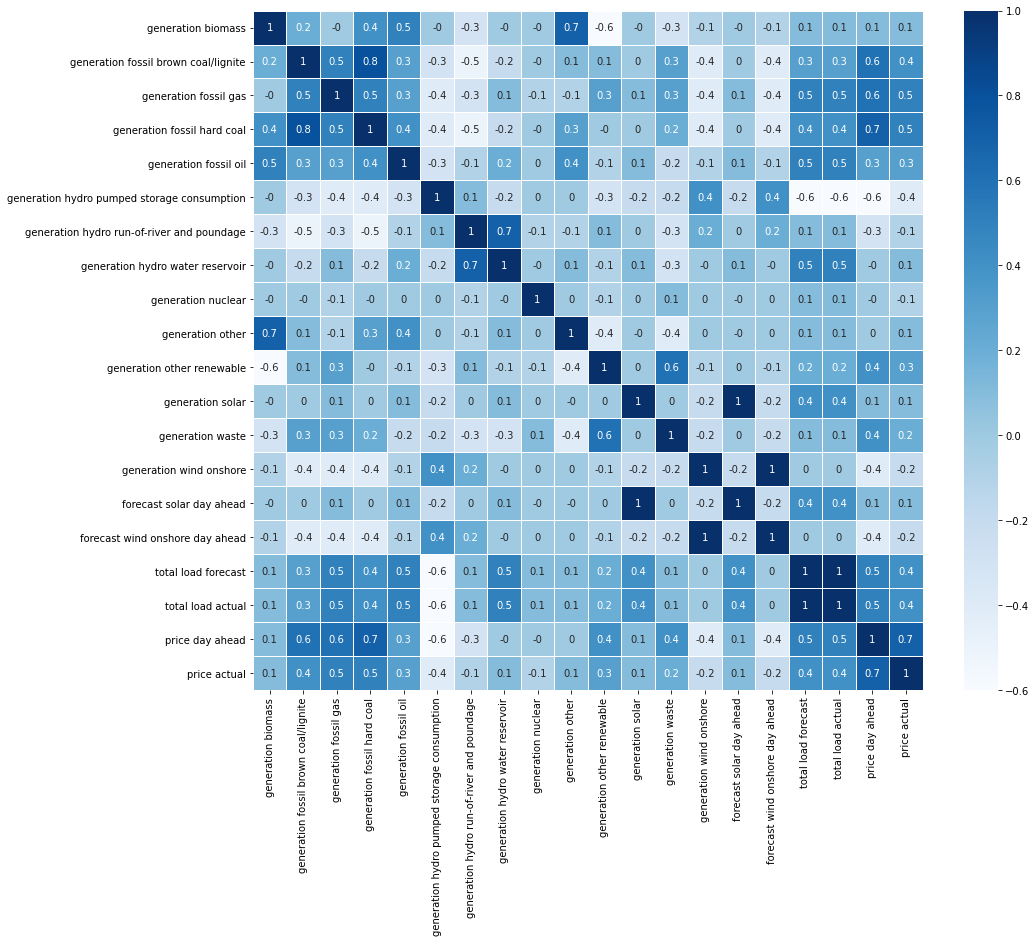

In [9]:
# Assign Variable to drop columns
zero_val_cols = ['generation marine',
                 'generation geothermal',
                 'generation fossil peat',
                 'generation wind offshore',
                 'generation fossil oil shale',
                 'forecast wind offshore eday ahead',
                 'generation fossil coal-derived gas',
                 'generation hydro pumped storage aggregated']

# Drop Columns with zero values
heat_map_features = df.drop(columns=zero_val_cols,axis=1)

# Set Figure Size
plt.figure(figsize=(15,12.5))

# .corr heatmap of df to visualize correlation & show plot
sns.heatmap(round(heat_map_features.corr(),1),annot=True,cmap='Blues',linewidth=0.9)
plt.show();

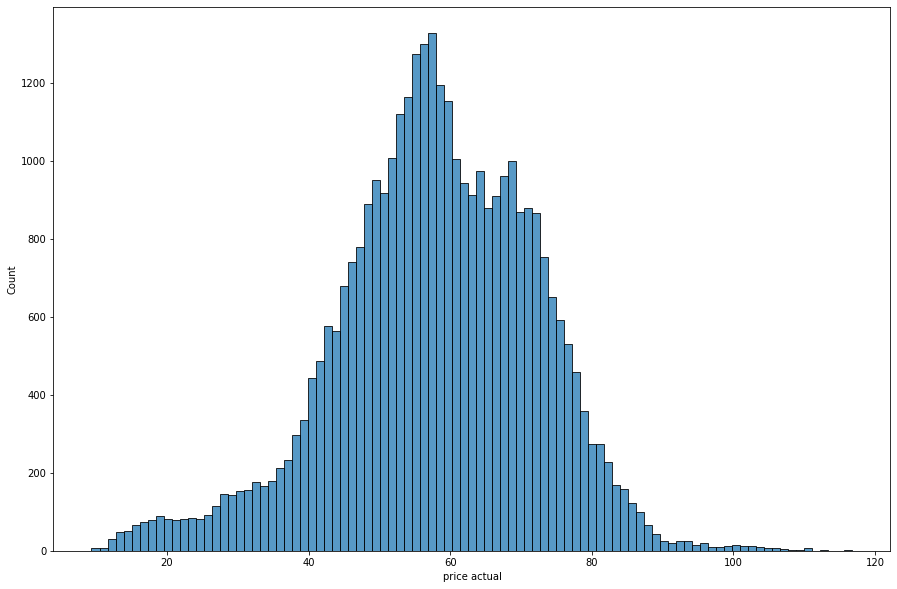

In [10]:
# Figure Size
plt.figure(figsize=(15,10))

# Hist graph to show distribution of target variable
sns.histplot(df,x='price actual');

## 1.2. Data Exploration Findings -
* Normal distrubution of target variable.
* Low percentage of nan values in columns without 100% nan.
* Lots of columns with 0 values for certain energy genreation types.
* Found very high correlation between some columns.
* All data seems to be numeric.

## 1.3. Data Cleaning -

In [11]:
# Wrangle function to clean data
def wrangle(filepath):
    
    '''
                 ,,,,,,,
      (\-"""-/) /       \
       |     | /         \
       \ 0 0 //           \
        \_o_//       /\   /
       /`   `\      |  \,/  
      /       \     |  
      \ (   ) /     |
     / \_)-(_/ \    |
    |  /_____\  |  /
    \  \ N.C / /  /
     \ '.___.' / /
    .'  \-=-/  '.
   /   /`   `\   \
  (//./       \.\\)
   `"`         `"`
   
    '''
    
    # Read in the data, parse dates, and set the index
    df = pd.read_csv(filepath,parse_dates=['time'],index_col='time')
 
    # Rename columns by replacing all - or blank space with _
    df.columns = df.columns.str.replace(' ','_').str.replace('-','_')

    # Make the index DT
    df.index = pd.to_datetime(df.index, utc=True)    

    # Drop all columns with data leakage, or 90% + null
    df.drop(columns=['price_day_ahead',
                     'generation_marine',
                     'total_load_forecast',
                     'generation_geothermal',
                     'generation_fossil_peat',
                     'generation_wind_offshore',
                     'forecast_solar_day_ahead',
                     'generation_fossil_oil_shale',
                     'forecast_wind_onshore_day_ahead',
                     'forecast_wind_offshore_eday_ahead',
                     'generation_fossil_coal_derived_gas',
                     'generation_hydro_pumped_storage_aggregated'],inplace=True)
    
    # Drop Outlier row 2014 for plotting
    df = df.drop(pd.Timestamp('2014-12-31 23:00:00+00:00')) 
    
    # Sort index
    df = df.sort_index()
    
    # Set conditional satements for filtering times of month to season value
    condition_winter = (df.index.month>=1)&(df.index.month<=3)
    condtion_spring = (df.index.month>=4)&(df.index.month<=6)
    condition_summer = (df.index.month>=7)&(df.index.month<=9)
    condition_automn = (df.index.month>=10)@(df.index.month<=12)
    
    # Create column in dataframe that inputs the season based on the conditions created above
    df['season'] = np.where(condition_winter,'winter',
                            np.where(condtion_spring,'spring',
                                     np.where(condition_summer,'summer',
                                              np.where(condition_automn,'automn',np.nan))))

    return df

# Applying the wrangle function to the dataset
df=wrangle('../input/energy-consumption-generation-prices-and-weather/energy_dataset.csv')

## 1.4. Data Cleaning Notes -
* Removed forecasted columns to prevent data leakage.
* Removed all columns with 0 fill for all values.
* Removed only row from 2014 for plotting purposes.
* Feature engineered seasons using time of year.

In [12]:
# Figure showing Price per total load
fig = px.scatter(df,x='total_load_actual',
                 y='price_actual',
                 facet_col='season',
                 opacity=0.1,
                 title='Price Per KW Hour Compaired To Total Energy Genereated Per Season',
                 animation_frame=df.index.year)

# Figure customizations
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='darkslateblue')),
                  selector=dict(mode='markers'))

# 2. ML Model Creation -

## 2.1. Split Data -

In [13]:
# Create Target variable
target='price_actual'

# Split data into feature matrix and target vector
y,X=df[target],df.drop(columns=target)

# split data into train / validation sets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.2,random_state=42)

## 2.2. Baselines -

In [14]:
# Assign variables for baselines and calculate baselines
y_pred = [y_train.mean()]*len(y_train)
mean_baseline_pred = y_train.mean()
baseline_mae = mean_absolute_error(y_train,y_pred)
baseline_rmse = mean_squared_error(y_train,y_pred,squared=False)

# Print statement to show all baseline values
print('Mean Price Per KW/h Baseline Pred:', mean_baseline_pred)
print('-------------------------------------------------------------------')
print('Baseline Mae:',baseline_mae)
print('-------------------------------------------------------------------')
print('Baseline RMSE:',baseline_rmse)

Mean Price Per KW/h Baseline Pred: 57.92005454545454
-------------------------------------------------------------------
Baseline Mae: 11.08589652244369
-------------------------------------------------------------------
Baseline RMSE: 14.21051579246629


## 2.3. Default Model Creation -

In [15]:
# One Hot Encoder to transform Seasons column
onehot = OneHotEncoder(use_cat_names=True)
onehot_fit = onehot.fit(X_train)
XT_train = onehot.transform(X_train)
XT_val = onehot.transform(X_val)

# Simple imputer to fill nan values, then transform sets
simp = SimpleImputer(strategy='mean')
simp_fit = simp.fit(XT_train)
XT_train = simp.transform(XT_train)
XT_val = simp.transform(XT_val)

# Assigning model variables
model_lr=LinearRegression()
model_r=Ridge()

# Fitting models
model_r.fit(XT_train,y_train);
model_lr.fit(XT_train,y_train);

# Def to check model metrics of baseline performance
def check_metrics(model):
    print(model)
    print('===================================================================')
    print('Training MAE:', mean_absolute_error(y_train,model.predict(XT_train)))
    print('-------------------------------------------------------------------')
    print('Validation MAE:', mean_absolute_error(y_val,model.predict(XT_val)))
    print('-------------------------------------------------------------------')
    print('Validation R2 score:', model.score(XT_val,y_val))
    print('===================================================================')
model = [model_r,model_lr]
for m in model:
  check_metrics(m)

Ridge()
Training MAE: 8.064800345014538
-------------------------------------------------------------------
Validation MAE: 8.12846909947165
-------------------------------------------------------------------
Validation R2 score: 0.4265774820282501
LinearRegression()
Training MAE: 8.064818613080801
-------------------------------------------------------------------
Validation MAE: 8.128466596401552
-------------------------------------------------------------------
Validation R2 score: 0.4265793720525828


In [16]:
# Ordinal Encoder to transform Seasons column
ordinal = OrdinalEncoder()
ordinal_fit = ordinal.fit(X_train)
XT_train = ordinal.transform(X_train)
XT_val = ordinal.transform(X_val)

# Simple imputer to fill nan values, then transform sets
simp = SimpleImputer(strategy='mean')
simp_fit = simp.fit(XT_train)
XT_train = simp.transform(XT_train)
XT_val = simp.transform(XT_val)

# Assigning model variables
model_rfr = RandomForestRegressor()
model_xgbr=XGBRegressor()

# Fitting models
model_rfr.fit(XT_train,y_train);
model_xgbr.fit(XT_train,y_train);

# Def to check model metrics of baseline performance
def check_metrics(model):
    print(model)
    print('===================================================================')
    print('Training MAE:', mean_absolute_error(y_train,model.predict(XT_train)))
    print('-------------------------------------------------------------------')
    print('Validation MAE:', mean_absolute_error(y_val,model.predict(XT_val)))
    print('-------------------------------------------------------------------')
    print('Validation R2 score:', model.score(XT_val,y_val))
    print('===================================================================')
model = [model_xgbr,model_rfr]
for m in model:
  check_metrics(m)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Training MAE: 3.1555856219327385
-------------------------------------------------------------------
Validation MAE: 4.1872117304859735
-------------------------------------------------------------------
Validation R2 score: 0.838064164425508
RandomForestRegressor()
Training MAE: 1.2163878911522923
-------------------------------------------------------------------
Validation MAE: 3.241241079732568
------------------------

## 2.3.1. Default Model Results (Without Feature Engineering) -

#### Ridge -
* Training MAE: 8.472823575635683
* Validation MAE: 8.63383328893237
* R2 score: 0.35638687883377895

#### LinearRegression - 
* Training MAE: 8.472823557244569
* Validation MAE: 8.633833278291645
* R2 score: 0.3563868756924954

#### XGBRegressor -
*  Training MAE: 3.545327560560801
*  Validation MAE: 4.6979849457995755
*  R2 score: 0.7950966649998653

#### RandomForestRegressor -
*  Training MAE: 1.4598095162420663
*  Validation MAE: 3.9252298502111427
*  R2 score: 0.8349323474716535

### 2.3.2. Defualt Model Observations -

* RandomForestRegressor seems to out perform any other model.
* Ridge Regression / Linear Regression have very similar outputs with no parameter tuning.

### 2.3.3. Default Model + Feature Engineering Observations -

* Increase of validation scores from 3-7%
    * HUGE improvement

## 2.4. XGB RandomSearch -

In [17]:
# Pipeline variable for RandomSearch
pipe_rs_xgb = make_pipeline(OrdinalEncoder(),
                            SimpleImputer(),
                            XGBRegressor(random_state=42,
                                         n_jobs=-1))

# Params for RandomSearch
paramajama = {'simpleimputer__strategy':['meadian','mean'],
              'xgbregressor__max_depth':range(5,35,5),
              'xgbregressor__learning_rate':np.arange(0.2,1,0.1),
              'xgbregressor__booster':['gbtree','gblinear','dart'],
              'xgbregressor__min_child_weight':range(1,10,1),
              'xgbregressor__gamma':np.arange(0,1,0.1),
              'xgbregressor__max_delta_step':np.arange(0,1,0.1),
              'xgbregressor__subsample':np.arange(0.5,1,0.1)}

# RandomSearch Model
model_rs_xgbr = RandomizedSearchCV(pipe_rs_xgb,
                                   param_distributions = paramajama,
                                   n_iter=20,
                                   n_jobs=-1)

# Model fit
model_rs_xgbr.fit(X_train,y_train);

# Check model metrics
print('Training MAE:', mean_absolute_error(y_train,model_rs_xgbr.predict(X_train)))
print('-------------------------------------------------------------------')
print('Validation MAE:', mean_absolute_error(y_val,model_rs_xgbr.predict(X_val)))
print('-------------------------------------------------------------------')
print('R2 score:', model_rs_xgbr.score(X_val,y_val))
print('===================================================================')
model_rs_xgbr.best_params_

Training MAE: 0.9618962260363574
-------------------------------------------------------------------
Validation MAE: 3.684015301636821
-------------------------------------------------------------------
R2 score: 0.8599949556477473


{'xgbregressor__subsample': 0.8999999999999999,
 'xgbregressor__min_child_weight': 4,
 'xgbregressor__max_depth': 25,
 'xgbregressor__max_delta_step': 0.9,
 'xgbregressor__learning_rate': 0.9000000000000001,
 'xgbregressor__gamma': 0.30000000000000004,
 'xgbregressor__booster': 'gbtree',
 'simpleimputer__strategy': 'mean'}

## 2.4.1. XGB RandomSearch Conclusions -

(20 random searches with 100 iter. Scaled down for kaggle notebook import) 
* RandomSearch model out performed the default with tuning.
* Highest score listed - .8991
    * Highest scoring model.
* I'm interested in grid search performance post project to see if the model can outperform the random searches.

### Best Score -
* Training MAE: 0.18182096506754555
* Validation MAE: 3.143150404572878
* R2 score: 0.8991961935947261

#### Params -
*  'xgbregressor__subsample': 0.7,
*  'xgbregressor__min_child_weight': 4,
*  'xgbregressor__max_depth': 25,
*  'xgbregressor__max_delta_step': 0.0,
*  'xgbregressor__learning_rate': 0.2,
*  'xgbregressor__gamma': 0.5,
*  'xgbregressor__booster': 'dart',
*  'simpleimputer__strategy': 'mean'}
 
### Second Best Score -
* Training MAE: 0.22435663695989874
* Validation MAE: 3.6606957501289457
* R2 score: 0.8619067640247029

## 2.5. Random Forest Regressor RandomSearch -

In [18]:
# Pipeline variable for RandomSearch
pipe_rs_rfr = make_pipeline(OrdinalEncoder(),
                            SimpleImputer(),
                            RandomForestRegressor(random_state=42,
                                                  n_jobs=-1))

# Params for RandomSearch
pramajams = {'simpleimputer__strategy':['mean','meadian'],
             'randomforestregressor__max_depth':range(5,35,5),
             'randomforestregressor__n_estimators':range(25,200,10),
             'randomforestregressor__max_samples':np.arange(0.2,1,0.1),
             'randomforestregressor__max_features':['sqrt','log2'],
             'randomforestregressor__min_samples_split':np.arange(2,5,1)}

# RandomSearch Model
model_rs_rfr = RandomizedSearchCV(pipe_rs_rfr,
                                  param_distributions=pramajams,
                                  n_iter=20,
                                  n_jobs=-1)

# Model fit
model_rs_rfr.fit(X_train,y_train);

# Check model metrics
print('Training MAE:', mean_absolute_error(y_train,model_rs_rfr.predict(X_train)))
print('-------------------------------------------------------------------')
print('Validation MAE:', mean_absolute_error(y_val,model_rs_rfr.predict(X_val)))
print('-------------------------------------------------------------------')
print('R2 score:', model_rs_rfr.score(X_val,y_val))
print('===================================================================')
model_rs_rfr.best_params_

Training MAE: 2.0128316012138967
-------------------------------------------------------------------
Validation MAE: 3.6739031175738996
-------------------------------------------------------------------
R2 score: 0.859925990958265


{'simpleimputer__strategy': 'mean',
 'randomforestregressor__n_estimators': 175,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__max_samples': 0.6000000000000001,
 'randomforestregressor__max_features': 'log2',
 'randomforestregressor__max_depth': 30}

## 2.5.1. Random Forest Regressor RandomSearch Conclusions -

(20 random searches with 100 iter. Scaled down for kaggle notebook import) 
* Default model out performed the RandomSearch with tuning.
* Highest score listed - .8795
* Model did not out perform the default model.

### Best Score -

* Training MAE: 1.4004700781578163
* Validation MAE: 3.371529047081576
* R2 score: 0.8795676540229065

#### Params -
*  'simpleimputer__strategy': 'mean',
*  'randomforestregressor__n_estimators': 115,
*  'randomforestregressor__min_samples_split': 2,
*  'randomforestregressor__max_samples': 0.9000000000000001,
*  'randomforestregressor__max_features': 'sqrt',
*  'randomforestregressor__max_depth': 25
 
### Second Best Score -

* Training MAE: 1.4371681333507431
* Validation MAE: 3.398423017100202
* R2 score: 0.877617516249465

## 2.6. Grid Search RandomForestRegressor -

In [19]:
# Pipeline variable for GridSearch
# pipe_it_up = make_pipeline(OrdinalEncoder(),
#                            SimpleImputer(),
#                            RandomForestRegressor(random_state=42,n_jobs=-1))

# Params for GridSearch
# pramajams = {'randomforestregressor__max_depth':range(0,35,5),
#              'randomforestregressor__n_estimators':range(100,200,10),
#              'randomforestregressor__max_samples':np.arange(0,1,0.1),
#              'randomforestregressor__max_features':['sqrt','log2'],
#              'randomforestregressor__criterion':['mse','mae'],
#              'randomforestregressor__min_samples_split':np.arange(2,5,1)}

# GridSearch Model
# model_rfr_two = GridSearchCV(pipe_it_up,
#                              param_grid=pramajams,
#                              n_jobs=-1)

# Model fit
# model_rfr_two.fit(X_train,y_train)

# Check model metrics
# print('Training MAE:',mean_absolute_error(y_train,model_rfr_two.predict(X_train)))
# print('-------------------------------------------------------------------')
# print('Validation MAE:',mean_absolute_error(y_val,model_rfr_two.predict(X_val)))
# print('-------------------------------------------------------------------')
# print('R2 score:',model_rfr_two.sore(X_val,y_val))
# print('===================================================================')
# model_rfr_two.best_params_

## 2.7. Results -

* I ran grid search model for 1.5 days and pulled the plug because of time running thin. I would like to re-run my model post project completion to see if I can find an improvement in r^2 score.
    * Since the default model outperformed all random searches I'm interested to see if any tuning is needed, or if the default model truly scores the highest.

# 3. Model Visualizations -

## 3.1 Feature Importance - 

In [20]:
#Set samp variable to show features when plotting 
samp = pd.DataFrame(XT_val,columns=ordinal_fit.get_feature_names())

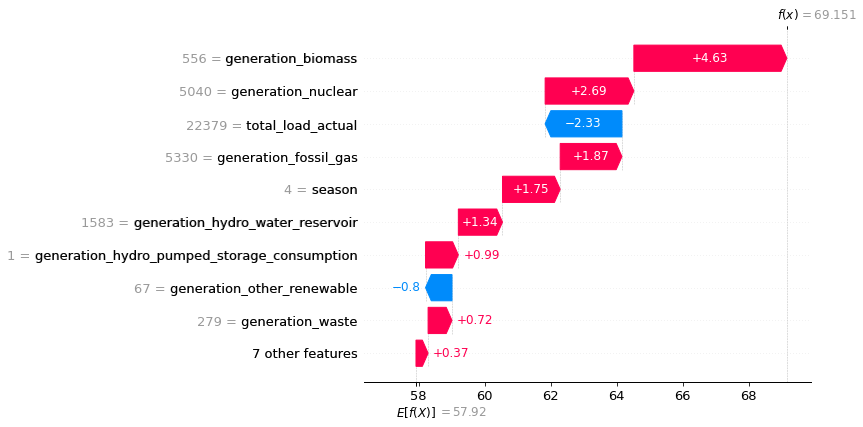

In [21]:
# Shap waterfall plot showing feature importance
explainer = shap.TreeExplainer(model_xgbr)
shap_values=explainer(samp.head(1))
shap.plots.waterfall(shap_values[0])

In [22]:
# Shap force plot also showing feature importance
explainer = shap.TreeExplainer(model_xgbr)
shap_values = explainer.shap_values(samp.head(1))
shap.initjs()
shap.force_plot(base_value = explainer.expected_value,
                shap_values=shap_values,
                features=samp.head(1))

In [23]:
# Permutation importance for features used in XGBR model
perm = PermutationImportance(model_xgbr,random_state=42).fit(XT_val,y_val)
eli5.show_weights(perm, feature_names = samp.columns.tolist())

Weight,Feature
0.3951 ± 0.0126,season
0.2125 ± 0.0097,generation_fossil_gas
0.1417 ± 0.0056,generation_fossil_hard_coal
0.1350 ± 0.0063,generation_nuclear
0.1269 ± 0.0066,generation_other_renewable
0.0970 ± 0.0049,generation_hydro_run_of_river_and_poundage
0.0873 ± 0.0052,total_load_actual
0.0739 ± 0.0031,generation_biomass
0.0706 ± 0.0071,generation_fossil_brown_coal/lignite
0.0698 ± 0.0039,generation_waste


## 3.2 Feature/Permutation Importance Conclusions - 

* Since shap doesn't seem to agree with RandomForestRegressor.. these are the results for the second best model.
* Generation biomass seems to have the highest importance, followed by generation nuclear.
* The feature engineered column seems to have the highest permutation importance value, followed by generation fossil gas.